# Baseline model for claim classification

In this notebook, we'll explore basic ML models to train and make inferences about the veracity of environment related claims. These models, such as _linear regression_ and _naive bayes_, are simplier, faster and more easily interpretable than more advanced deep learning approaches. 

The results from this exercise will be used as reference point for the claim classification project. 

In [1]:
# import required libraries
import numpy as np 
import pandas as pd
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

### Load data

Import data from previously produced csv files

In [2]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")
val_df = pd.read_csv("../data/val_data.csv")

# remove nans. they cant be vectorized
train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

In [3]:
val_df.head()

,clean_text,label
0,there is ample evidence that earths average te...,DISPUTED
1,the ozone layer stops uv radiation from enteri...,SUPPORTS
2,despite the logarithmic relationship between c...,SUPPORTS
3,as a result the polar ice caps were quite like...,NEUTRAL
4,an additional kick was supplied by an el niño ...,NEUTRAL


### Separate features and labels

We’ll train on _clean_text_ and predict _label_

In [4]:
x_list = ['clean_text']
y_list = ['label']

x_train, y_train = train_df[x_list], train_df[y_list]
x_test, y_test   = test_df[x_list], test_df[y_list]
x_val, y_val     = val_df[x_list], val_df[y_list]

y_train = y_train.values.ravel() # flaten so it's labels are 1D
y_test  = y_test.values.ravel() # flaten so it's labels are 1D
y_val   = y_val.values.ravel() # flaten so it's labels are 1D

print(x_train.shape)
print(y_train.shape)

(1074, 1)
(1074,)


### Baseline pipeline

We'll use **TF-IDF** (Term Frequency - Inverse Document Frequency) with **Logistic Regression**

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [6]:
# # Build pipeline
# baseline = Pipeline([
#     ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
#     ("clf", LogisticRegression(max_iter=1000))
# ])

# # Train
# baseline.fit(x_train['clean_text'], y_train)

# # Evaluate
# val_acc = baseline.score(x_val['clean_text'], y_val)
# test_acc = baseline.score(x_test['clean_text'], y_test)

# print(f"Validation Accuracy: {val_acc:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")

We want to be able to use not just the text, but the domain as a model feature.

In [7]:
# Preprocessor: text + categorical domain
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("text", TfidfVectorizer(max_features=10000, stop_words="english"), "clean_text"),
#         ("domain", OneHotEncoder(handle_unknown="ignore"), ["domain"]),
#     ]
# )

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=10000, stop_words="english"), "clean_text")
    ]
)

# Pipeline
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Train
clf.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=10000,
                                                                  stop_words='english'),
                                                  'clean_text')])),
                ('classifier', LogisticRegression(max_iter=1000))])

### Baseline performance

Let's look at the overall performance, as well as how the model is doing per domain.

#### Performance metrics
**Overall**

In [8]:
from sklearn.metrics import classification_report

# Predictions
y_pred = clf.predict(x_test)

# Classification Report
print(classification_report(y_test, y_pred, target_names=["SUPPORTS", "REFUTES", "NEUTRAL", "DISPUTED"], zero_division=0))

print(type(y_test), y_test.shape)
print(type(y_pred), y_pred.shape)

              precision    recall  f1-score   support

    SUPPORTS       0.00      0.00      0.00        17
     REFUTES       0.44      0.41      0.42        69
     NEUTRAL       0.40      0.07      0.11        30
    DISPUTED       0.54      0.76      0.63       115

    accuracy                           0.51       231
   macro avg       0.34      0.31      0.29       231
weighted avg       0.45      0.51      0.45       231

<class 'numpy.ndarray'> (231,)
<class 'numpy.ndarray'> (231,)


#### Confusion matrix
**Overall**

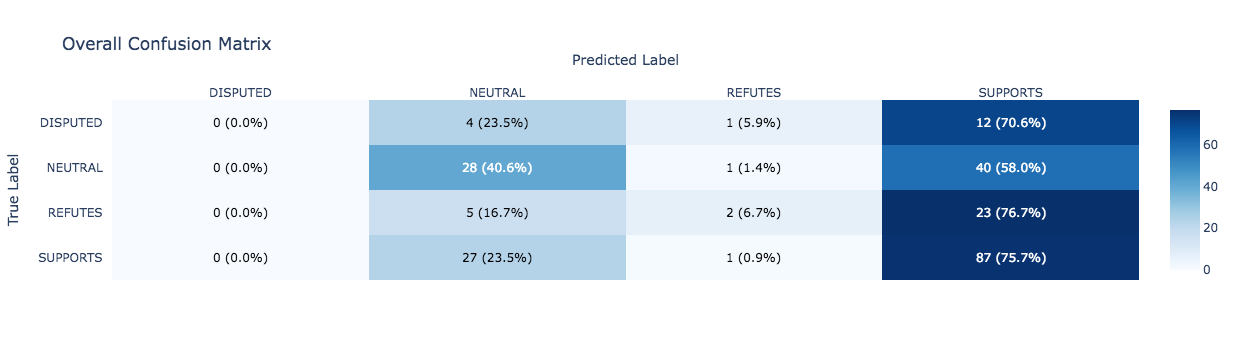

In [9]:
from src.viz import * 

labels_in_test = list(np.unique(y_test))

# Overall confusion matrix
plotly_confusion_matrix(y_test, y_pred, labels=labels_in_test, title="Overall Confusion Matrix")

Confusion matrices by domain

In [10]:
# for d in np.unique(x_test["domain"]):
#     subset_idx = x_test["domain"] == d
    
#     y_true_subset = np.array(y_test[subset_idx]).ravel()
#     y_pred_subset = np.array(y_pred[subset_idx]).ravel()
#     labels_subset = list(np.unique(y_true_subset))
    
#     plotly_confusion_matrix(
#         y_true_subset,
#         y_pred_subset,
#         labels=labels_subset,
#         title=f"Confusion Matrix: Domain={d}"
#     )

#### Feature importance

Logistic Regression coefficients tell us what words are most indicative of _FAKE_ vs _REAL_ news.

In [14]:
import pandas as pd
import numpy as np
import plotly.express as px

# Feature names
feature_names = clf.named_steps["preprocessor"].get_feature_names_out()
# Remove "text__" prefix
feature_names = [f.replace("text__", "") for f in feature_names]

# Coefficients
coefs = clf.named_steps["classifier"].coef_[0]  # LogisticRegression with multi-class has shape (n_classes, n_features)

# For multi-class, coefs has shape (n_classes, n_features)
# Let's pick one-vs-rest for "SUPPORTS" vs others, for example
# Or use all classes separately
feature_weights_list = []
class_labels = clf.named_steps["classifier"].classes_

for i, label in enumerate(class_labels):
    coefs_i = coefs if len(class_labels) == 2 else clf.named_steps["classifier"].coef_[i]
    df_i = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs_i,
        "Label": label
    })
    feature_weights_list.append(df_i)

feature_weights = pd.concat(feature_weights_list)

# Select top positive and negative for each label
top_n = 10
top_features_list = []

for label in class_labels:
    df_label = feature_weights[feature_weights["Label"]==label]
    top_pos = df_label.sort_values("Coefficient", ascending=False).head(top_n)
    top_neg = df_label.sort_values("Coefficient").head(top_n)
    top_features_list.append(pd.concat([top_neg, top_pos]))

top_features = pd.concat(top_features_list)

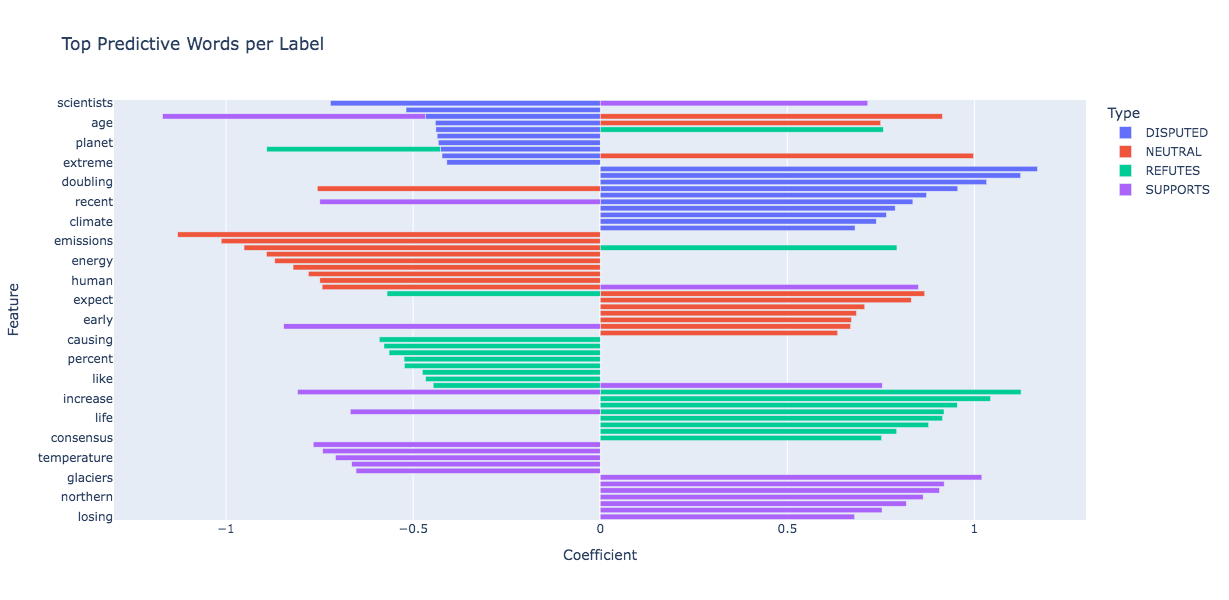

In [15]:
# Add type for coloring (label)
top_features["Type"] = top_features["Label"]

# Plot
fig = px.bar(
    top_features,
    x="Coefficient",
    y="Feature",
    color="Type",
    orientation="h",
    title="Top Predictive Words per Label",
    height=600
)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

**Word cloud**

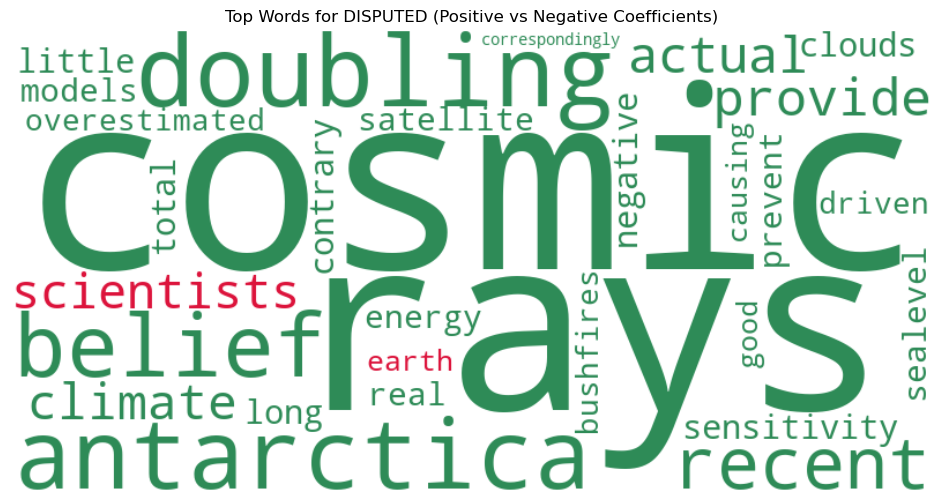

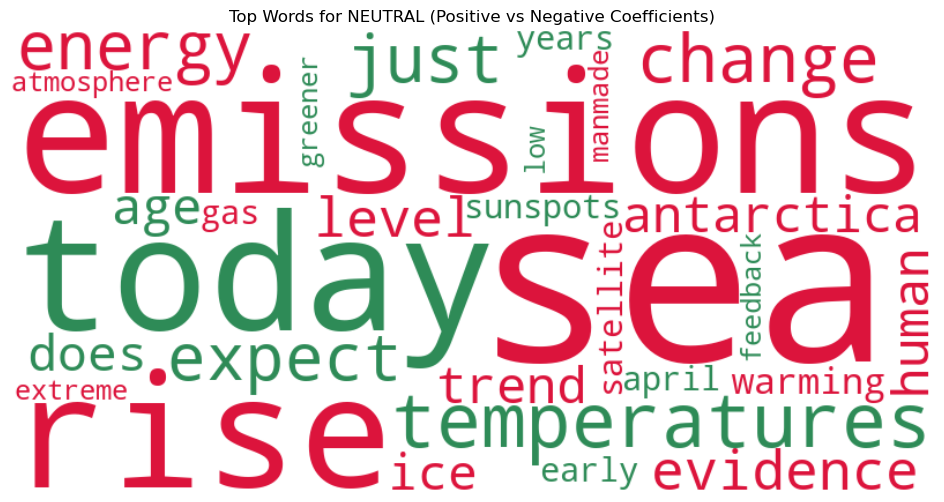

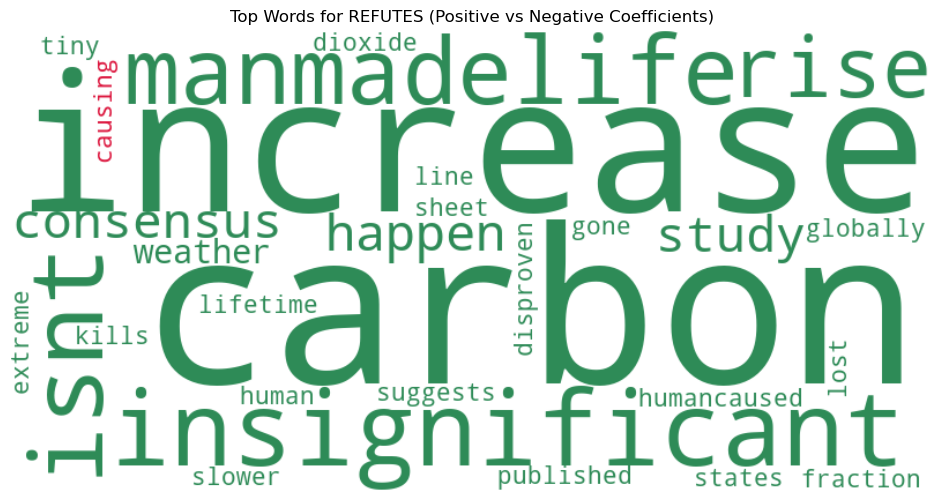

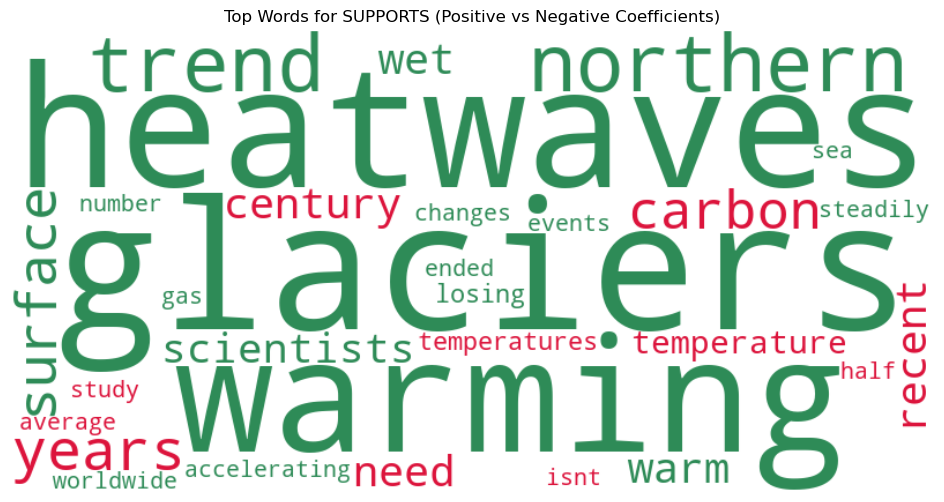

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

feature_names = clf.named_steps["preprocessor"].get_feature_names_out()
# Remove "text__" prefix
feature_names = [f.replace("text__", "") for f in feature_names]

class_labels = clf.named_steps["classifier"].classes_
coefs = clf.named_steps["classifier"].coef_  # shape (n_classes, n_features)

# Custom color function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word_colors[word] > 0:
        return "seagreen"  # positive coefficient
    else:
        return "crimson"   # negative coefficient

top_n_words = 30

for i, label in enumerate(class_labels):
    coef_dict = dict(zip(feature_names, coefs[i]))
    
    # Select top_n_words by absolute value
    top_words = dict(sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n_words])
    
    # Use absolute values for font size
    freq_dict = {word: abs(coef) for word, coef in top_words.items()}
    
    # Keep track of original signs for color
    word_colors = top_words
    
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(freq_dict)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc.recolor(color_func=color_func), interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Top Words for {label} (Positive vs Negative Coefficients)")
    plt.show()